Import Libraries

In [7]:
import librosa
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

from tensorflow.keras.utils import plot_model



In [8]:
def extract_features(audio_path):
    audio, sample_rate = librosa.load(audio_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=20)
    mfccs_processed = np.mean(mfccs.T, axis=0)
    return mfccs_processed

In [3]:
def load_data(base_dir, protocol_path):
    data = pd.read_csv(protocol_path, sep=' ', header=None, names=['speaker_id','filename','system_id','null','class_name'])
    features, labels = [], []
    for index, row in data.iterrows():
        file_path = os.path.join(base_dir, row['filename'] + '.flac')
        # print(file_path)
        mfcc = extract_features(file_path)
        features.append(mfcc)
        labels.append(1 if row['class_name'] == 'bonafide' else 0)
    return np.array(features), np.array(labels)

In [10]:
def plot_mfccs(features, labels):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, alpha=0.5)
    plt.title('MFCCs Feature Distribution')
    plt.xlabel('MFCC 1')
    plt.ylabel('MFCC 2')
    plt.legend(title='Label', labels=['Fake', 'Real'])
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [5]:
# Path to the training dataset and protocol
base_dir = './input/asvspoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac'
protocol_path = './input/asvspoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt'

In [6]:
# Load and prepare the dataset
X, y = load_data(base_dir, protocol_path)

Logistic Regression Model

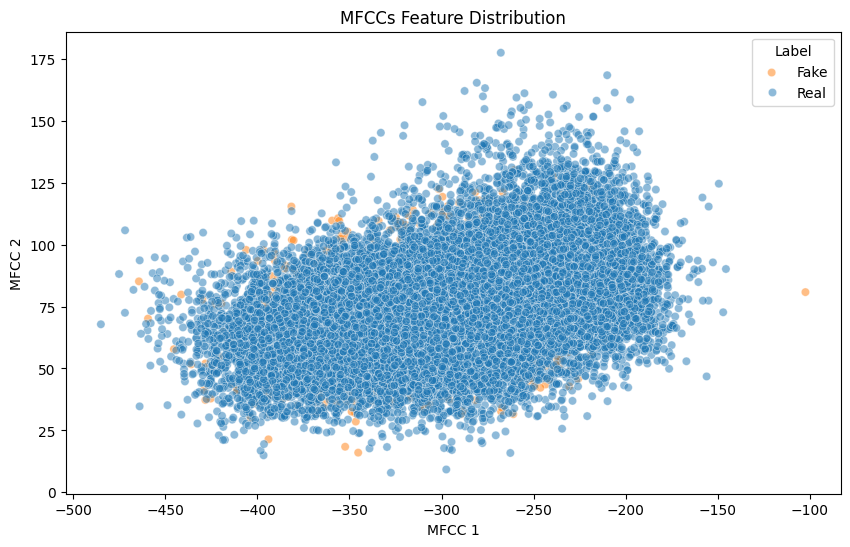

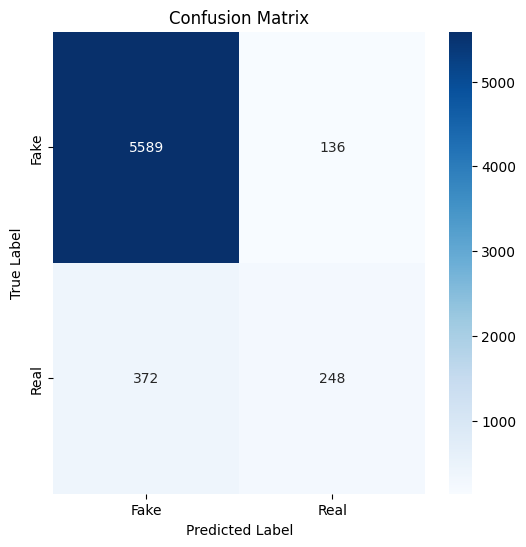

In [25]:
plot_mfccs(X,y)
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train)

predictions = model.predict(X_test)
plot_confusion_matrix(y_test, predictions)

In [26]:
# Evaluate the model
accuracy = accuracy_score(y_test, predictions)*100
recall = recall_score(y_test, predictions)*100  # Assumes the positive class is 1
precision = precision_score(y_test, predictions)*100  # Assumes the positive class is 1
f1 = f1_score(y_test, predictions)*100  # Harmonic mean of precision and recall
print(f'Accuracy: {accuracy:.2f}%')
print(f"Recall: {recall:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"F1 Score: {f1:.2f}%")

Accuracy: 91.99%
Recall: 40.00%
Precision: 64.58%
F1 Score: 49.40%


CNN Model

In [13]:
def cnn_load_data(base_dir, protocol_path,output_spectrogram_dir): 

    # Create output directories if they don't exist
    os.makedirs(output_spectrogram_dir, exist_ok=True)


    real_output_dir = os.path.join(output_spectrogram_dir, 'real')
    fake_output_dir = os.path.join(output_spectrogram_dir, 'fake')

    os.makedirs(real_output_dir, exist_ok=True)
    os.makedirs(fake_output_dir, exist_ok=True)
    
    real_val_dir = './output/validation/real'
    fake_val_dir = './output/validation/fake'
    data = pd.read_csv(protocol_path, sep=' ', header=None, names=['speaker_id','filename','system_id','null','class_name'])
    for index, row in data.iterrows():
        file_path = os.path.join(base_dir, row['filename'] + '.flac')
        if row['class_name'] == 'bonafide':
            if not os.path.exists(os.path.join(real_output_dir, row['filename']+'.png')) and not os.path.exists(os.path.join(real_val_dir, row['filename']+'.png')):
                process_directory(row['filename'], real_output_dir)
        else:
            if not os.path.exists(os.path.join(fake_output_dir, row['filename']+'.png')) and not os.path.exists(os.path.join(fake_val_dir, row['filename']+'.png')):
                process_directory(row['filename'], fake_output_dir)


def save_spectrogram(audio, sample_rate, filename):
    stft = librosa.stft(audio)
    db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(db, sr=sample_rate, x_axis='time', y_axis='log', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.savefig(filename)
    plt.close()


def process_directory(filename, output_dir):
    audio_path = os.path.join(base_dir, filename+'.flac')
    audio, sample_rate = librosa.load(audio_path, sr=None)
    output_filename = os.path.join(output_dir, os.path.splitext(filename)[0] + '.png')
    save_spectrogram(audio, sample_rate, output_filename)



def create_datagen(train_dir, val_dir, img_width, img_height, batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary'
    )

    validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    return train_generator, validation_generator


In [18]:
def create_cnn_model(input_shape):
    model = Sequential([
        Input(input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Assuming the spectrograms are 150x150 pixels
cnn_model = create_cnn_model((150, 150, 3))

In [15]:
cnn_load_data(base_dir, protocol_path, './output/spectograms')

# Split the data into training(75%) and testing(25%) using the following commands on the terminal
# mv -- *([1,5700]) output/validation/fake
# mv -- *([1,645]) output/validation/real

In [16]:
def validate_images(image_directory):
    for root, dirs, files in os.walk(image_directory):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                try:
                    img_path = os.path.join(root, file)
                    img = Image.open(img_path)  # Open the image file
                    img.verify()  # Verify that it is, in fact, an image
                except (IOError, SyntaxError) as e:
                    print('Bad file:', img_path)  # Print out the names of corrupt files

validate_images('./output/spectograms/real')
validate_images('./output/spectograms/fake')
validate_images('./output/validation/real')
validate_images('./output/validation/fake')


In [19]:

train_generator,validation_generator = create_datagen('./output/spectograms','./output/validation', 150, 150, 32)
history = cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=11
)

Found 19116 images belonging to 2 classes.
Found 6345 images belonging to 2 classes.
Epoch 1/11


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


598/598 ━━━━━━━━━━━━━━━━━━━━ 295s 489ms/step - accuracy: 0.8951 - loss: 0.5202 - val_accuracy: 0.8983 - val_loss: 0.2283
Epoch 2/11
598/598 ━━━━━━━━━━━━━━━━━━━━ 293s 485ms/step - accuracy: 0.8982 - loss: 0.2632 - val_accuracy: 0.8976 - val_loss: 0.1952
Epoch 3/11
598/598 ━━━━━━━━━━━━━━━━━━━━ 292s 484ms/step - accuracy: 0.8925 - loss: 0.2539 - val_accuracy: 0.8983 - val_loss: 0.1901
Epoch 4/11
598/598 ━━━━━━━━━━━━━━━━━━━━ 1233s 2s/step - accuracy: 0.8952 - loss: 0.2325 - val_accuracy: 0.9171 - val_loss: 0.1736
Epoch 5/11
598/598 ━━━━━━━━━━━━━━━━━━━━ 290s 480ms/step - accuracy: 0.9020 - loss: 0.2109 - val_accuracy: 0.9270 - val_loss: 0.1499
Epoch 6/11
598/598 ━━━━━━━━━━━━━━━━━━━━ 292s 484ms/step - accuracy: 0.9077 - loss: 0.1995 - val_accuracy: 0.9292 - val_loss: 0.1497
Epoch 7/11
598/598 ━━━━━━━━━━━━━━━━━━━━ 293s 486ms/step - accuracy: 0.9102 - loss: 0.1941 - val_accuracy: 0.9357 - val_loss: 0.1389
Epoch 8/11
598/598 ━━━━━━━━━━━━━━━━━━━━ 293s 486ms/step - accuracy: 0.9146 - loss: 0.1835

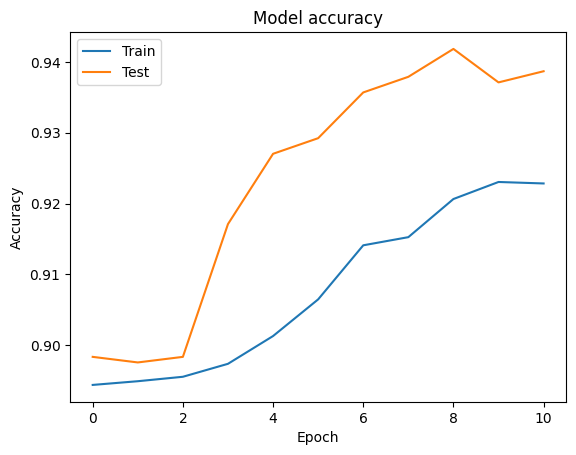

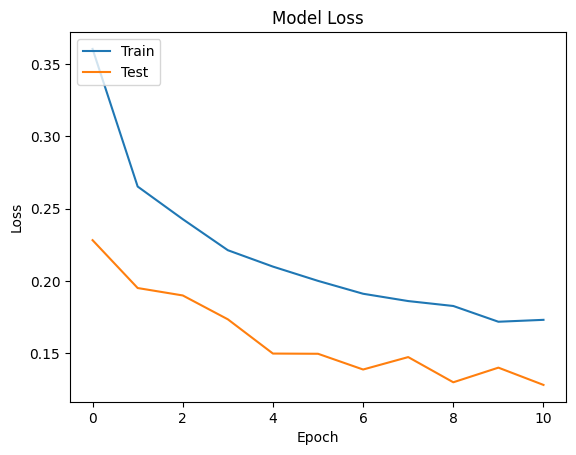

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



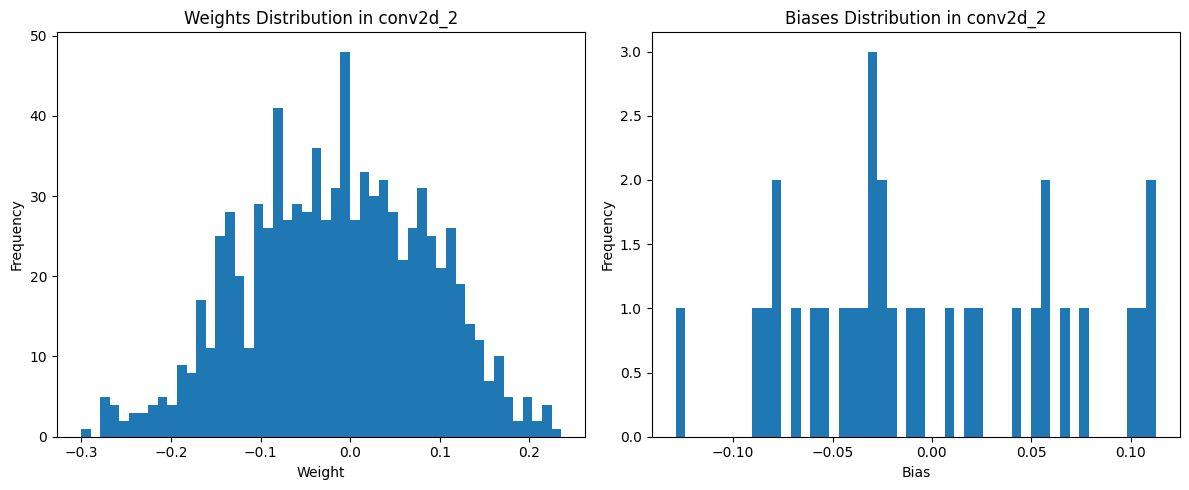

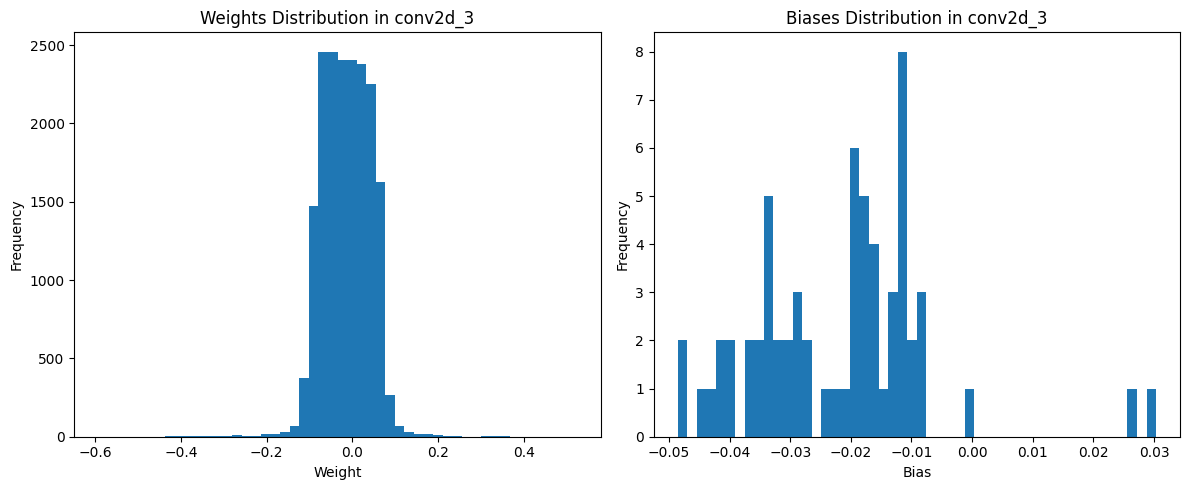

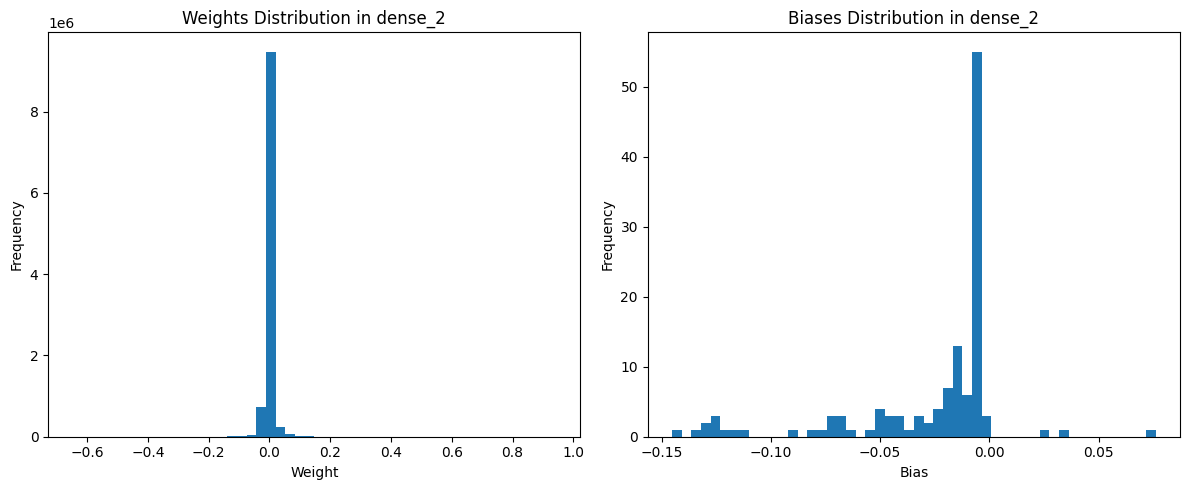

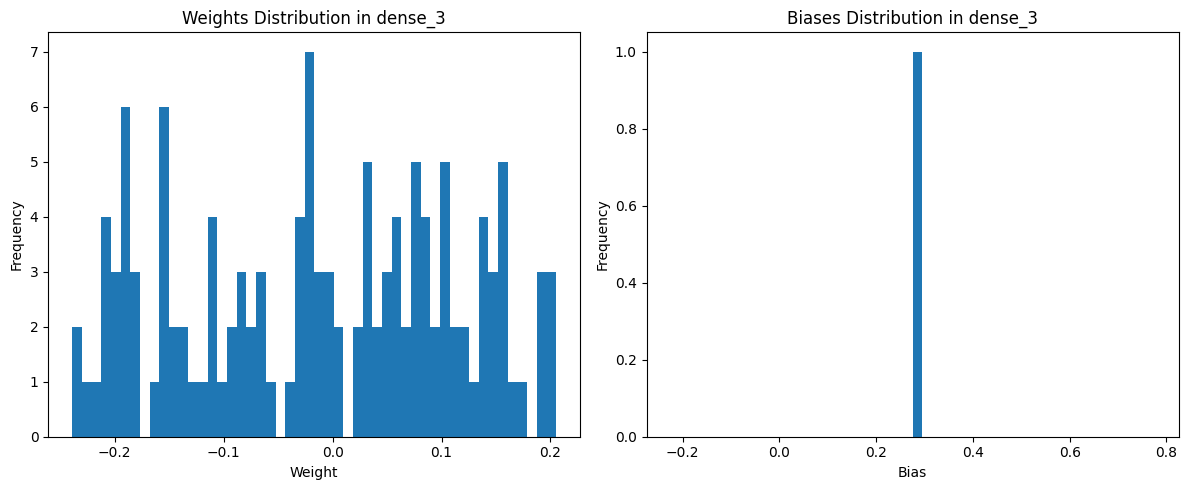

In [21]:
def plot_layer_weights(layer_name, model):
    weights = model.get_layer(layer_name).get_weights()[0]  # Get the weights
    biases = model.get_layer(layer_name).get_weights()[1]  # Get the biases
    
    plt.figure(figsize=(12, 5))

    # Plotting the weights
    plt.subplot(1, 2, 1)
    plt.hist(weights.flatten(), bins=50)
    plt.title(f'Weights Distribution in {layer_name}')
    plt.xlabel('Weight')
    plt.ylabel('Frequency')

    # Plotting the biases
    plt.subplot(1, 2, 2)
    plt.hist(biases.flatten(), bins=50)
    plt.title(f'Biases Distribution in {layer_name}')
    plt.xlabel('Bias')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

for layer in cnn_model.layers:
    if type(layer) is Conv2D or type(layer) is Dense:
        plot_layer_weights(layer.name, cnn_model)


199/199 ━━━━━━━━━━━━━━━━━━━━ 62s 313ms/step


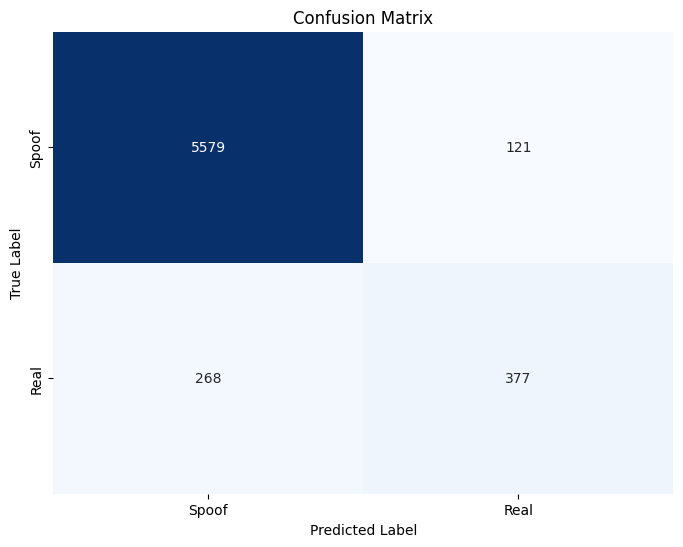

In [22]:
validation_generator.reset()  # Reset the generator to be sure of the order
predictions = cnn_model.predict(validation_generator)

y_pred = (predictions > 0.5).astype(int)  # Convert probabilities to 0 or 1

y_true = validation_generator.classes[:len(y_pred)]  # Ensure the length matches y_pred if the last batch is incomplete

cm = confusion_matrix(y_true, y_pred)

class_names = ['Spoof', 'Real']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Calculate metrics
accuracy_cnn = accuracy_score(y_true, y_pred)*100
recall_cnn = recall_score(y_true, y_pred)*100  # Assumes the positive class is 1
precision_cnn = precision_score(y_true, y_pred)*100  # Assumes the positive class is 1
f1_cnn = f1_score(y_true, y_pred)*100  # Harmonic mean of precision and recall

# Print metrics
print(f"Accuracy: {accuracy_cnn:.2f}%")
print(f"Recall: {recall_cnn:.2f}%")
print(f"Precision: {precision_cnn:.2f}%")
print(f"F1 Score: {f1_cnn:.2f}%")


Accuracy: 93.87%
Recall: 58.45%
Precision: 75.70%
F1 Score: 65.97%
